In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

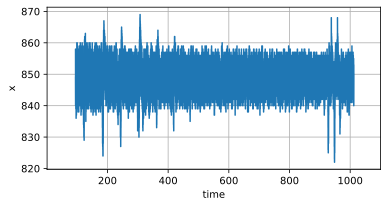

In [2]:
import codecs

filecp = codecs.open('C:\\Users\\Anthony\\Desktop\\Curve\\Curve\\target.txt', encoding ='utf-8')
file_data = np.loadtxt(filecp, usecols=(0,1),skiprows=1)

time = list(file_data[:, 1])
x = list(file_data[:, 0])
time = torch.tensor(time)
x = torch.tensor(x)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1100], figsize=(6, 3))

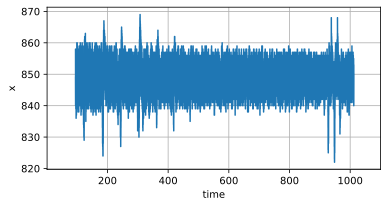

In [3]:
T = 91162
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1100], figsize=(6, 3))

In [4]:
# 马尔科夫假设
# 将数据映射为数据对y_t = x_t和x_t = [x_(t-tao),...,x_(t-1)]
tau = 10
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 32, 90000
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [5]:
# 定义一个只有两个全连接层的感知机
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(10, 1000), nn.ReLU(),
                        nn.Linear(1000, 500), nn.ReLU(),
                        nn.Linear(500, 100), nn.ReLU(),
                        nn.Linear(100, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [6]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X).float(), y.float())
            l.backward()
            trainer.step()
        print(f"epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}")

In [7]:
net = get_net()
train(net, train_iter, loss, 800, 0.008)

epoch 1, loss: 113.120910
epoch 2, loss: 15.154765
epoch 3, loss: 43.379818
epoch 4, loss: 5.914127
epoch 5, loss: 5.052651
epoch 6, loss: 5.304620
epoch 7, loss: 24.151167
epoch 8, loss: 65.952423
epoch 9, loss: 31.577072
epoch 10, loss: 7.323443
epoch 11, loss: 15.130968
epoch 12, loss: 6.952896
epoch 13, loss: 22.817033
epoch 14, loss: 23.690396
epoch 15, loss: 15.813156
epoch 16, loss: 3.604180
epoch 17, loss: 36.338664
epoch 18, loss: 9.624351
epoch 19, loss: 24.395649
epoch 20, loss: 14.529122
epoch 21, loss: 8.221302
epoch 22, loss: 2.912697
epoch 23, loss: 5.299661
epoch 24, loss: 8.550563
epoch 25, loss: 24.303659
epoch 26, loss: 58.289733
epoch 27, loss: 4.965364
epoch 28, loss: 22.862610
epoch 29, loss: 15.102425
epoch 30, loss: 5.770474
epoch 31, loss: 4.416918
epoch 32, loss: 3.046746
epoch 33, loss: 8.466714
epoch 34, loss: 5.794007
epoch 35, loss: 3.753905
epoch 36, loss: 24.105700
epoch 37, loss: 2.962520
epoch 38, loss: 8.323063
epoch 39, loss: 2.702905
epoch 40, loss:

KeyboardInterrupt: 

In [ ]:
# 模型预测下一个时间步
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-steps preds'], xlim=[1, 1000], figsize=(6, 3))

In [ ]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau : i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train+tau:]],
         [x.detach().numpy(),
          onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

In [ ]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))